In [1]:
import pickle 
import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib.ticker import MaxNLocator
from data import * 

In [2]:
normalize = False
method_labels = ["Softmax", "Attention Covariate", "Relevance Covariate", "Logit Covariate"]
cc_method_labels = ["Class Softmax", 
                    "Class Softmax with Attention Covariate", 
                    "Class Softmax with Relevance Covariate",
                    "Class Conditional Softmax with Specific Covariate Shift"]


In [3]:
path = f'uq/metrics/IIIC/fixed_cov_cls_plot_nbs{normalize_by_sample()}.pkl'
with open(path, 'rb') as file:
    covariate_weighed_df = pickle.load(file)

csdf_path=f"uq/metrics/IIIC/cov_cls_plot_nbs{normalize_by_sample()}.pkl"
with open(csdf_path, 'rb') as file:
    covariate_score_df = pickle.load(file)

logit_rel_only_path = f"uq/metrics/IIIC/only_logit_rel_scores_cov_cls_plot_nbs{normalize_by_sample()}.pkl"
with open(logit_rel_only_path, 'rb') as file:
    logit_rel_score_df = pickle.load(file)
# print(df)

In [4]:
print(logit_rel_score_df.keys())

dict_keys(['Logit Covariate Score', 'Relevance Covariate Score'])


In [5]:
# data preprocessing 
score_df = {}
quantile_df = {}
for method in method_labels:
    quantile_df[method] = covariate_weighed_df[method]

for key, value in logit_rel_score_df.items():
    print("In logit_rel stuff", score_df.keys())
    score_df[key] = value

score_df["Softmax"] = {}
score_df["Attention Covariate Score"] = {}
for key, value in covariate_score_df.items():
    print(score_df.keys())
    if key == "acc_softmax":
        score_df["Softmax"]["acc"] = value 
    elif key == "acc_cov_softmax":
        score_df["Attention Covariate Score"]["acc"] = value
        

    elif key == "avg_len_softmax":
        score_df["Softmax"]["avg_len"] = value
    elif key == "avg_len_cov_softmax":
        score_df["Attention Covariate Score"]["avg_len"] = value

    elif key == "pset_len_softmax":
        score_df["Softmax"]["pset_len"] = value
    elif key == "pset_len_cov_softmax":
        score_df["Attention Covariate Score"]["pset_len"] = value
    

In logit_rel stuff dict_keys([])
In logit_rel stuff dict_keys(['Logit Covariate Score'])
dict_keys(['Logit Covariate Score', 'Relevance Covariate Score', 'Softmax', 'Attention Covariate Score'])
dict_keys(['Logit Covariate Score', 'Relevance Covariate Score', 'Softmax', 'Attention Covariate Score'])
dict_keys(['Logit Covariate Score', 'Relevance Covariate Score', 'Softmax', 'Attention Covariate Score'])
dict_keys(['Logit Covariate Score', 'Relevance Covariate Score', 'Softmax', 'Attention Covariate Score'])
dict_keys(['Logit Covariate Score', 'Relevance Covariate Score', 'Softmax', 'Attention Covariate Score'])
dict_keys(['Logit Covariate Score', 'Relevance Covariate Score', 'Softmax', 'Attention Covariate Score'])
dict_keys(['Logit Covariate Score', 'Relevance Covariate Score', 'Softmax', 'Attention Covariate Score'])
dict_keys(['Logit Covariate Score', 'Relevance Covariate Score', 'Softmax', 'Attention Covariate Score'])
dict_keys(['Logit Covariate Score', 'Relevance Covariate Score'

# Plotting

In [138]:
def plot_coverage(alphas, labels, colors, coverages, save_path):
    assert(len(coverages) == len(labels))
    plt.figure(figsize=(8,8))
    plt.title("Coverage", fontsize=18)
    plt.ylabel("Coverage", fontsize=14)
    plt.xlabel("Alpha", fontsize=14)
    plt.plot(alphas, 1- np.array(alphas), label="Ideal", color="black")
    for i in range(len(labels)):
        plt.plot(alphas, coverages[i], label=labels[i], color=colors[i], marker='o')
    plt.legend(fontsize=18)
    plt.savefig(save_path)

def plot_mean_len(alphas, labels, colors, mean_pred_lens, save_path):
    assert(len(mean_pred_lens) == len(labels))
    plt.figure(figsize=(8,8))
    plt.title("Mean Prediction Length", fontsize=18)
    plt.ylabel("Mean Prediction Length", fontsize=14)
    plt.xlabel("Alpha", fontsize=14)
    for i in range(len(labels)):
        plt.plot(alphas, mean_pred_lens[i], label=labels[i], color=colors[i], marker='o')
    plt.legend(fontsize=18)
    plt.savefig(save_path)

def plot_ratio(alphas, labels, colors, coverages, mean_pred_lens, save_path):
    assert(len(coverages) == len(mean_pred_lens) == len(labels))
    plt.figure(figsize=(8,8))
    plt.title("Coverage / Mean Prediction Length")
    plt.ylabel("Coverage / Mean Prediction Length")
    plt.xlabel("Alpha")
    for i in range(len(labels)):
        plt.plot(alphas, coverages[i] / mean_pred_lens, label=labels[i], color=colors[i])
    plt.legend(fontsize=14)
    
def plot_histograms(alphas, labels, hist_plots, colors, save_path):
    assert(len(hist_plots) == len(labels))
    fig, axes = plt.subplots(nrows=len(labels), ncols=len(alphas), figsize=(24,24))
    for i in range(len(hist_plots)):
        for j in range(len(alphas)):
            if j == 0:
                # only need labels for just 1
                axes[i,j].hist(hist_plots[i][j], bins=6, color=colors[i], label=labels[i])
                axes[i,j].set_ylabel("# of Samples", fontsize=20)
            else: 
                axes[i,j].hist(hist_plots[i][j], bins=6, color=colors[i])

            # plot alphas at the bottom of all the subplots
            # axes[i,j].set_title(hist_titles[i] + " Alpha: " + str(alphas[j]))
            axes[i,j].tick_params(axis='x', labelsize=12)
            axes[i,j].xaxis.set_major_locator(MaxNLocator(integer=True))
            
            # axes[i,j].set_xlabel("Prediction Set Lengths")
            if i== len(hist_plots) - 1:
                axes[i,j].set_xlabel("Size of Prediction Set \n Alpha: " + str(alphas[j]), fontsize=20)
    
    # legend_ax = fig.add_axes([0, 0, 1, 0.1]) 
    fig.legend(fontsize=24, loc = "lower center", ncol=2, bbox_to_anchor=(0.5, -0.01))
    # fig.tight_layout()
    plt.savefig(save_path)


In [139]:
# warm_color_palette = ["#FF5733", "#FFAA33", "#FFC733", "#FFEE33", "#FFD433"]
# cool_colors =  ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#937860', '#DA8BC3']
cool_colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00']
# cool_colors =  ['#87CEEB', '#98FB98', '#E6E6FA', '#D3D3D3']
warm_colors = ['#FF7F50', '#FFD700', '#E2725B', '#DC143C']
alphas = [0.01, 0.05, 0.1, 0.15]

# Softmax vs. Attn vs. Relevance vs Logits (Default Covariate Shift)


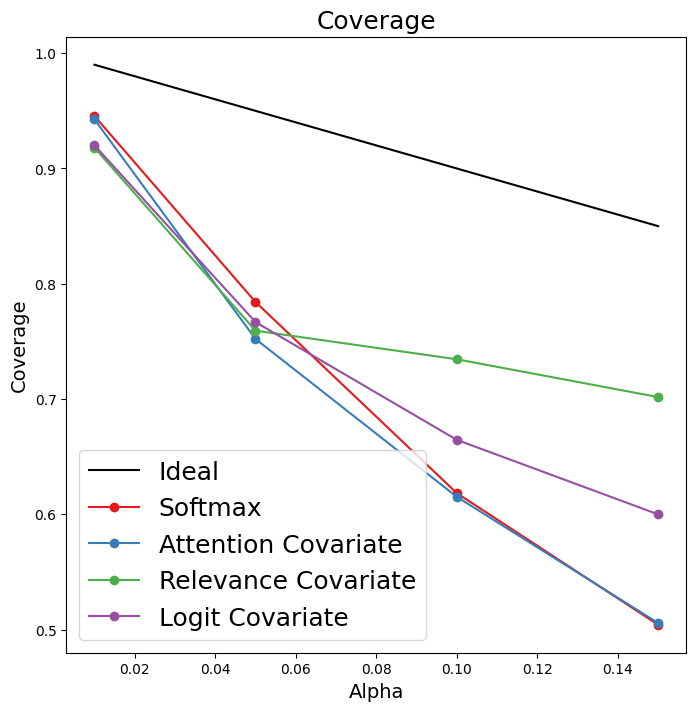

In [140]:
# get the coverage values for each method 
quantile_coverages_per_method =[]
for method in method_labels:
    quantile_coverages_per_method.append(quantile_df[method]["acc"])

plot_coverage(alphas, method_labels, cool_colors, quantile_coverages_per_method, "fig/cp/IIIC/q_cov_coverage.png")

(4, 35740)
(4, 35740)
(4, 35740)
(4, 35740)


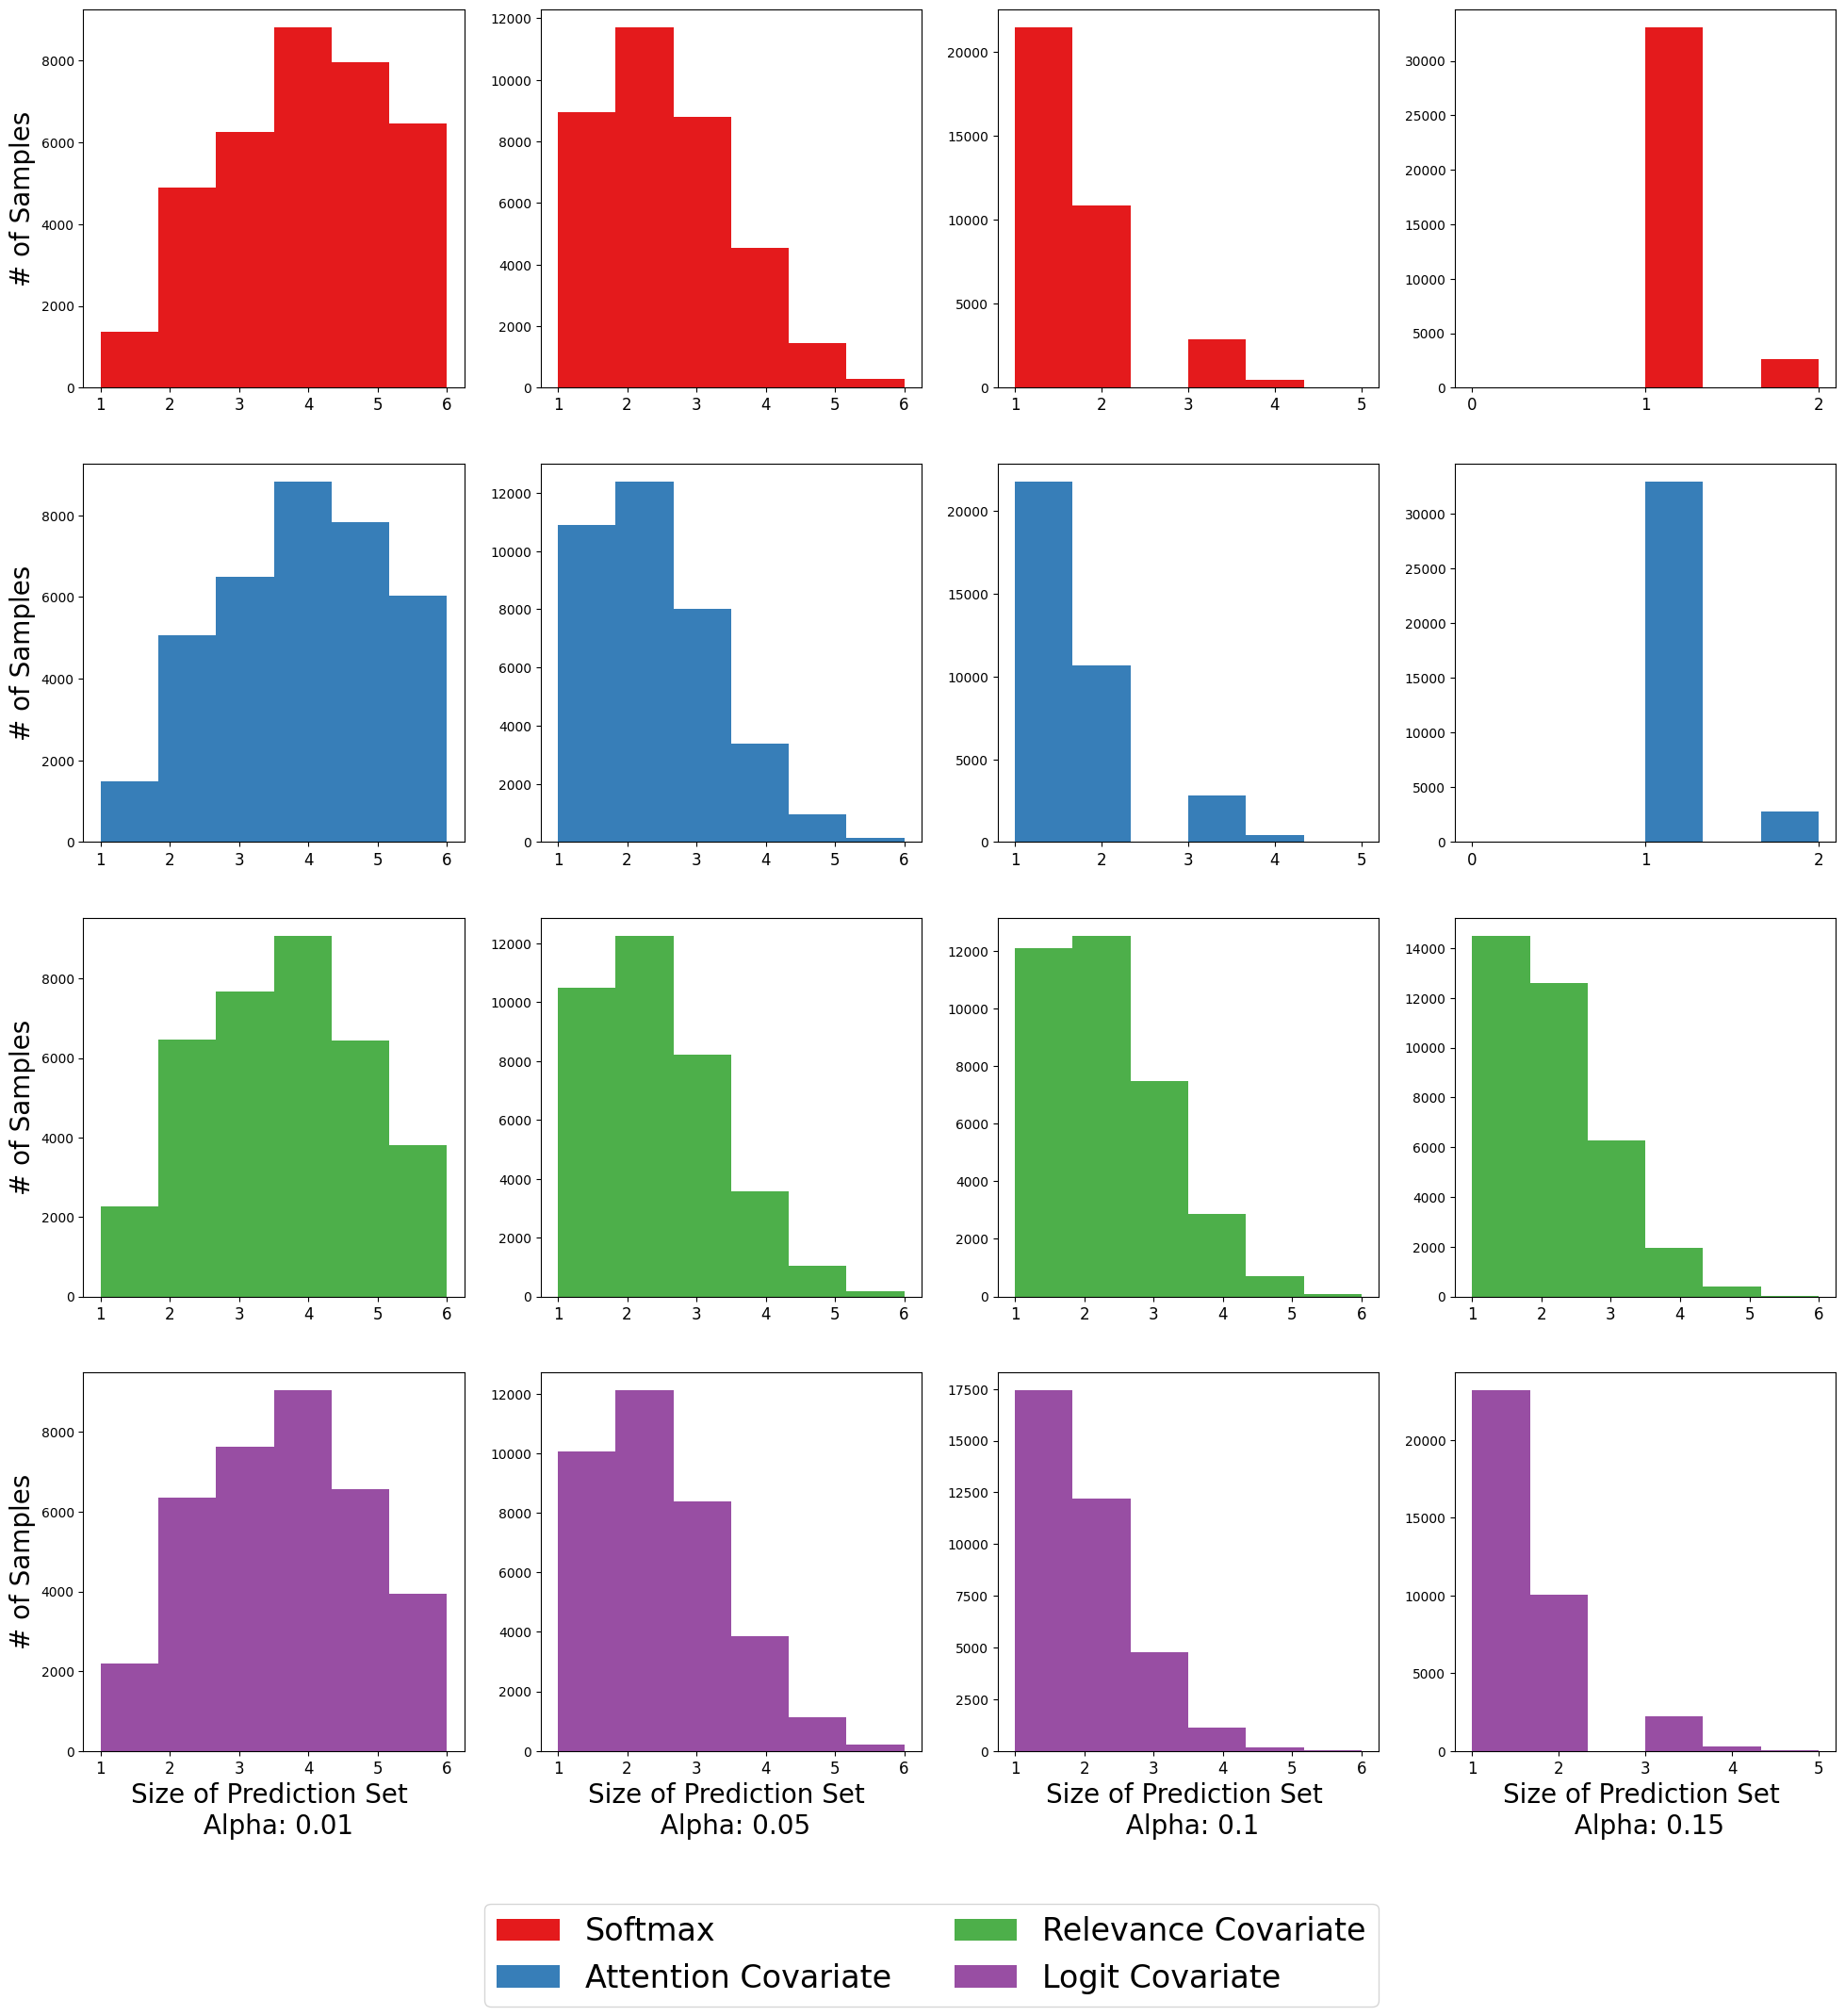

In [141]:
quantile_pset_lens_per_method =[]
for method in method_labels:
    quantile_pset_lens_per_method.append(quantile_df[method]["pset_len"])
    print(quantile_df[method]["pset_len"].shape)

plot_histograms(alphas, method_labels, quantile_pset_lens_per_method, cool_colors, "fig/cp/IIIC/q_cov_pset_len.png")
    # exit(0)

# Covariate Scores Instead

In [142]:
score_methods = ["Softmax", "Attention Covariate Score", "Relevance Covariate Score", "Logit Covariate Score"]

dict_keys(['Logit Covariate Score', 'Relevance Covariate Score', 'Softmax', 'Attention Covariate Score'])
4


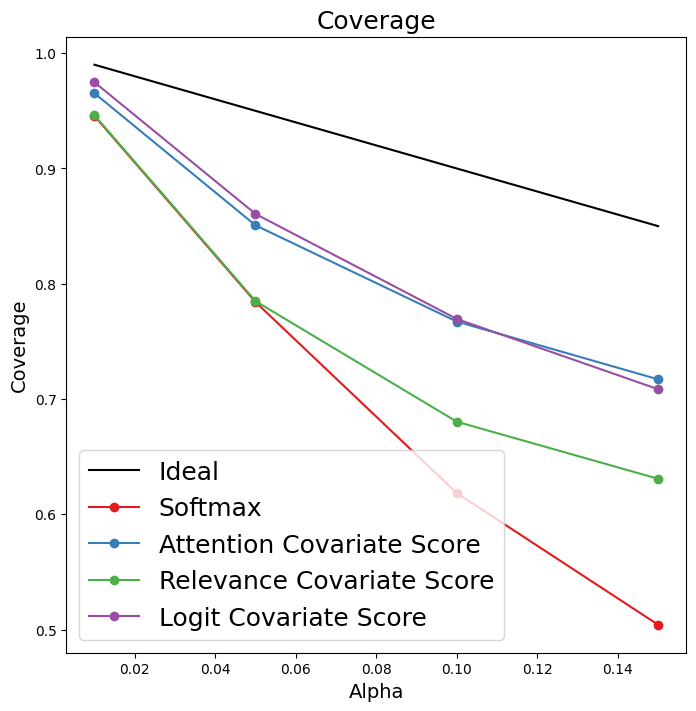

In [143]:
score_coverages_per_method = []
score_methods = ["Softmax", "Attention Covariate Score", "Relevance Covariate Score", "Logit Covariate Score"]
print(score_df.keys())
for method in score_methods:
    score_coverages_per_method.append(score_df[method]["acc"])
print(len(score_coverages_per_method))
plot_coverage(alphas, score_methods, cool_colors, score_coverages_per_method, "fig/cp/IIIC/score_cov_coverage.png")

(4, 35740)
(4, 35740)
(4, 35740)
(4, 35740)


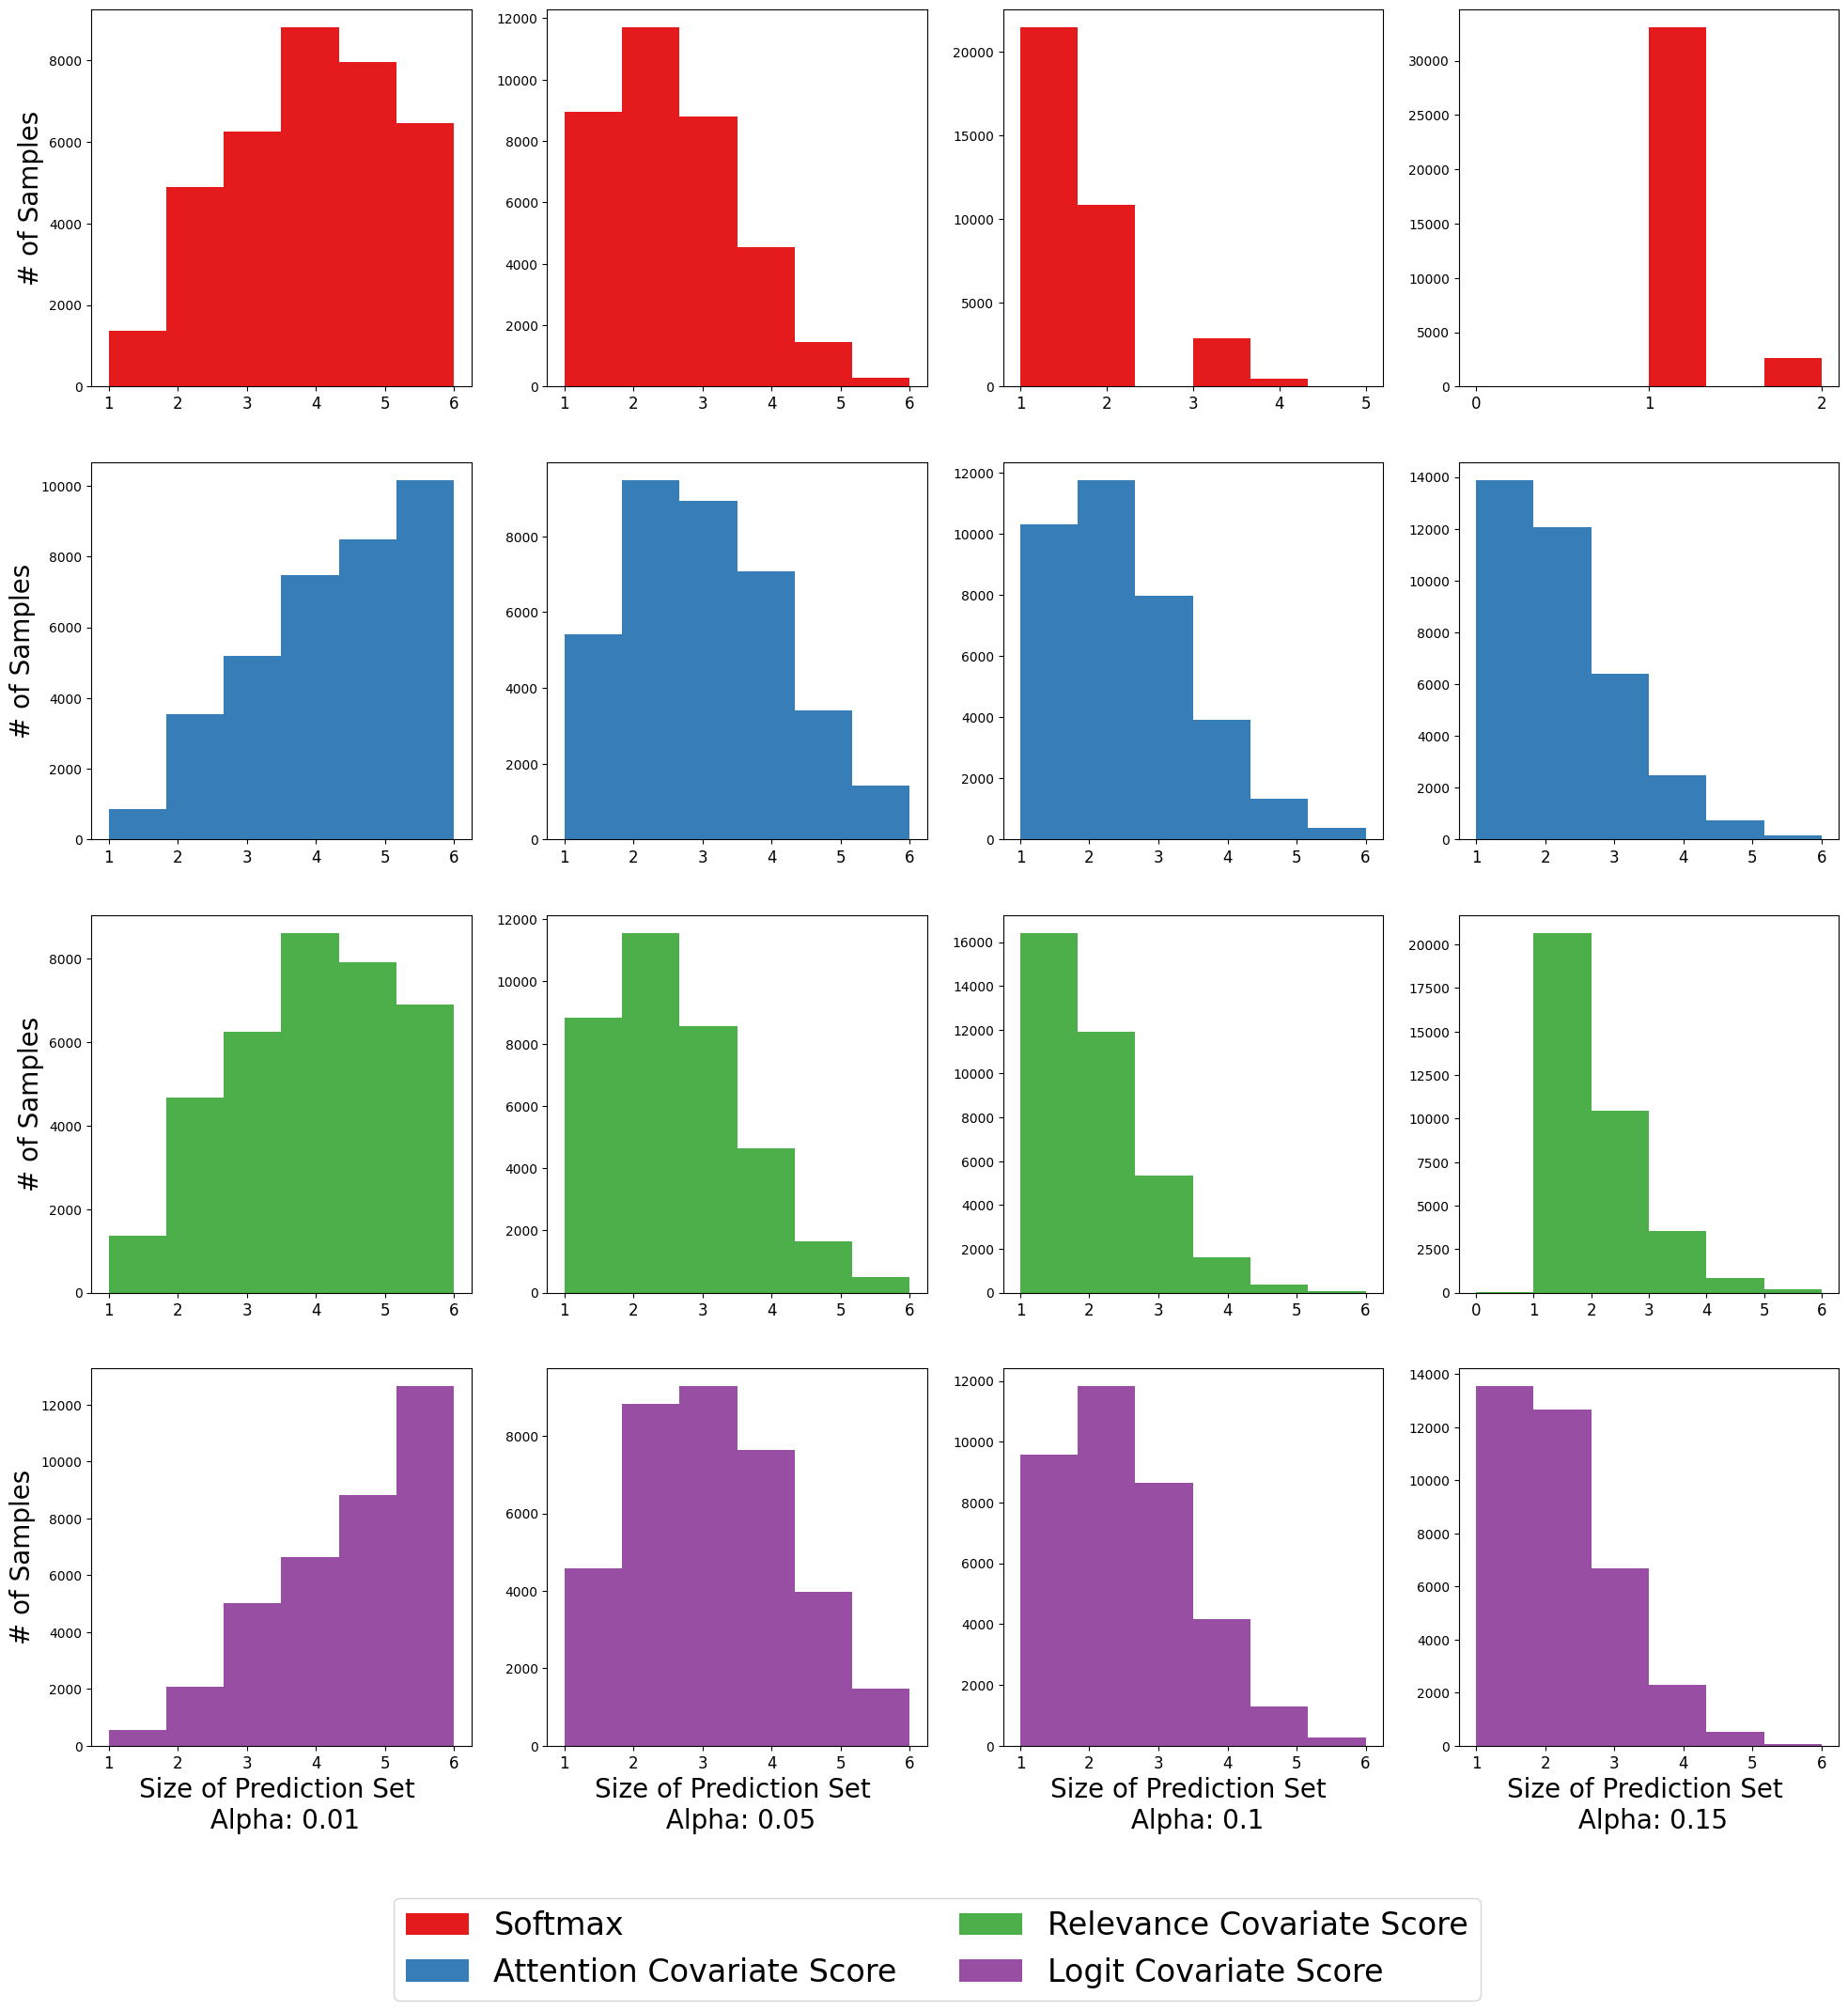

In [144]:
score_pset_lens_per_method =[]
for method in score_methods:
    score_pset_lens_per_method.append(score_df[method]["pset_len"])
    print(score_df[method]["pset_len"].shape)

plot_histograms(alphas, score_methods, score_pset_lens_per_method, cool_colors, "fig/cp/IIIC/score_cov_pset_len.png")

In [145]:
mean_pset_lens_per_method =[]
for method in score_methods:
    mean_pset_lens_per_method.append(score_df[method]["avg_len"])
    print(score_df[method]["avg_len"])

[4.01978176 2.40394516 1.50920537 1.0726357 ]
[4.38768886 2.94059877 2.31035255 2.01029659]
[4.05635143 2.44605484 1.82095691 1.58379966]
[4.65279799 3.05523223 2.34476777 1.98391158]


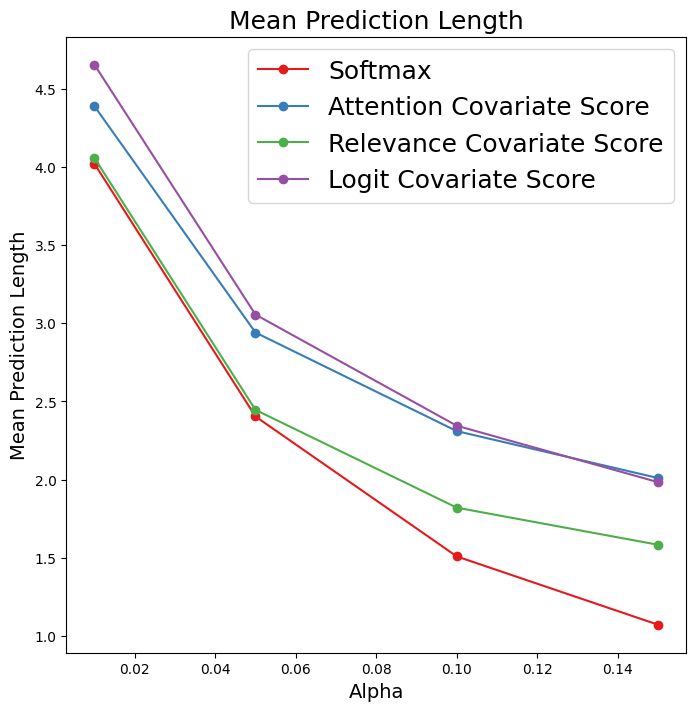

In [146]:
plot_mean_len(alphas, score_methods, cool_colors, mean_pset_lens_per_method, "fig/cp/IIIC/score_cov_mean_len.png")

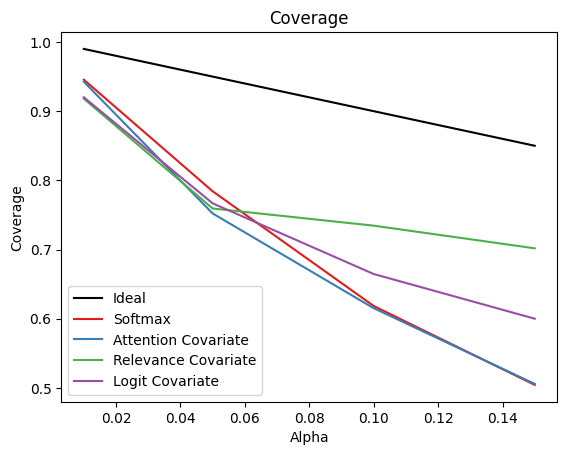

In [147]:
plt.figure()
alphas = [0.01, 0.05, 0.1, 0.15]
plt.title("Coverage")
plt.ylabel("Coverage")
plt.xlabel("Alpha")
plt.plot(alphas, 1- np.array(alphas), label="Ideal", color="black")
for i in range(4):
    label = method_labels[i]
    plt.plot(covariate_weighed_df[label]['alpha'], covariate_weighed_df[label]['acc'], label=label, color=cool_colors[i])
    plt.legend()

<Figure size 640x480 with 0 Axes>

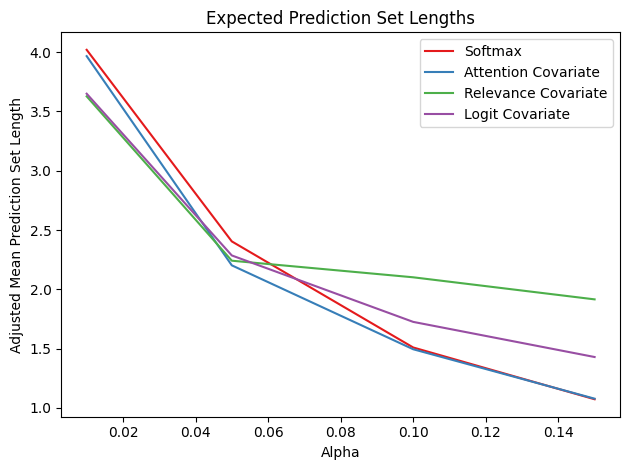

<Figure size 640x480 with 0 Axes>

In [148]:

for i in range(4):
    label = method_labels[i]
    plt.plot(covariate_weighed_df[label]['alpha'], covariate_weighed_df[label]['avg_len'], label=label, color=cool_colors[i])
    plt.legend()
plt.title("Expected Prediction Set Lengths")
plt.ylabel("Adjusted Mean Prediction Set Length")
plt.xlabel("Alpha")
plt.tight_layout()
plt.legend()
plt.figure()

# Our Coverage, Default (Softmax) vs. Attn vs. Rel vs. Logits

In [149]:
for i in range(4):
    label = cc_method_labels[i]
    plt.plot([0.01, 0.05, 0.1, 0.15] , df[label]['acc'], label=label, color=cool_colors[i])
    plt.legend()

NameError: name 'df' is not defined

In [ ]:
# read in qhats to see what's up
qhats_smax = pd.read_csv('uq/q_hat/IIIC/softmax_nbsFalse.csv')
qhats_att = pd.read_csv('uq/q_hat/IIIC/attn_cov_nbsFalse.csv')
qhats_rel = pd.read_csv('uq/q_hat/IIIC/rel_cov_nbsFalse.csv')

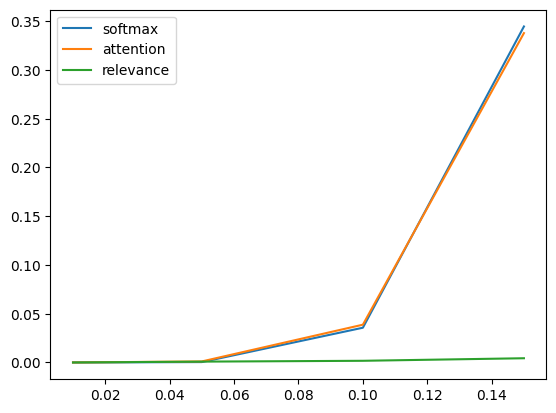

In [ ]:
plt.plot(qhats_smax['alpha'], qhats_smax['q_hat'], label='softmax')
plt.plot(qhats_att['alpha'], qhats_att['q_hat'], label='attention')
plt.plot(qhats_rel['alpha'], qhats_rel['q_hat'], label='relevance')
plt.legend()